# This notebook calculates urbanized portion of each culverts' watershed 
##### Author: Omid Emamjomehzadeh (https://www.omidemam.com/)
##### Supervisor: Dr. Omar Wani (https://engineering.nyu.edu/faculty/omar-wani)
##### Hydrologic Systems Group @NYU (https://www.omarwani.com/)

In [4]:
# libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import glob
import datetime

In [8]:
import warnings
# Suppress the specific RuntimeWarning
warnings.filterwarnings("ignore")
# Suppress all UserWarnings, including PerformanceWarnings
warnings.simplefilter('ignore', category=UserWarning)
# plot with Arial font
plt.rcParams['font.family'] = 'Arial'

# An example

In [5]:
# Set global font properties
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16

# File paths
nlcd_file = r"D:\culvert repo\data\initial layers\NLCD_2021_5070.tif"
watershed_shp = r"D:\culvert repo\Results\waterhsed_delineation_dir\011000050501\C810330watershed_poly_40m.shp"

# Load watershed polygon
watershed_gdf = gpd.read_file(watershed_shp)

# Define custom colors and class names for each class
custom_colors = {
    0: 'black',                    # Unclassified
    11: 'deepskyblue',             # Open Water
    21: 'lightyellow',             # Developed, Open Space
    22: 'wheat',                   # Developed, Low Intensity
    23: 'sandybrown',              # Developed, Medium Intensity
    24: 'firebrick',               # Developed High Intensity
    31: 'khaki',                   # Barren Land
    41: 'forestgreen',             # Deciduous Forest
    42: 'darkgreen',               # Evergreen Forest
    43: 'yellowgreen',             # Mixed Forest
    52: 'olivedrab',               # Shrub/Scrub
    71: 'palegreen',               # Herbaceous
    81: 'lightgreen',              # Hay/Pasture
    82: 'limegreen',               # Cultivated Crops
    90: 'royalblue',               # Woody Wetlands
    95: 'aquamarine'               # Emergent Herbaceous Wetlands
}

# Class descriptions for each code
class_descriptions = {
    0: 'Unclassified',
    11: 'Open Water',
    21: 'Developed, Open Space',
    22: 'Developed, Low Intensity',
    23: 'Developed, Medium Intensity',
    24: 'Developed High Intensity',
    31: 'Barren Land',
    41: 'Deciduous Forest',
    42: 'Evergreen Forest',
    43: 'Mixed Forest',
    52: 'Shrub/Scrub',
    71: 'Herbaceous',
    81: 'Hay/Pasture',
    82: 'Cultivated Crops',
    90: 'Woody Wetlands',
    95: 'Emergent Herbaceous Wetlands'
}

# Create a colormap based on custom colors
cmap = mcolors.ListedColormap([custom_colors[key] for key in sorted(custom_colors.keys())])

# Function to clip raster by polygon and calculate class proportions
def calculate_class_proportions(nlcd_file, watershed_gdf):
    with rasterio.open(nlcd_file) as src:
        # Clip raster to watershed polygon
        out_image, out_transform = mask(src, [mapping(watershed_gdf.geometry.iloc[0])], crop=True)
        out_image = np.ma.masked_where(out_image == -128, out_image)  # Mask NoData
        
        # Calculate proportions
        unique, counts = np.unique(out_image.compressed(), return_counts=True)
        total_pixels = counts.sum()
        proportions = {class_descriptions.get(int(k), 'Unknown'): v / total_pixels for k, v in zip(unique, counts)}
        
        return out_image, out_transform, proportions

# Clip and calculate proportions
clipped_data, transform, class_proportions = calculate_class_proportions(nlcd_file, watershed_gdf)
print("Class proportions within the watershed polygon:", class_proportions)


Class proportions within the watershed polygon: {'Developed, Open Space': np.float64(0.06565656565656566), 'Developed, Low Intensity': np.float64(0.016835016835016835), 'Developed, Medium Intensity': np.float64(0.0016835016835016834), 'Deciduous Forest': np.float64(0.30808080808080807), 'Hay/Pasture': np.float64(0.4696969696969697), 'Cultivated Crops': np.float64(0.06734006734006734), 'Woody Wetlands': np.float64(0.050505050505050504), 'Emergent Herbaceous Wetlands': np.float64(0.020202020202020204)}


# find the paths

In [6]:
# Gather all paths for different watershed files
# Define the root directory to search in
root_dir = r'D:\culvert repo\Results\waterhsed_delineation_dir'

# Define the pattern to search for shapefiles
pattern = os.path.join(root_dir, '**', '*watershed_poly_*m.shp')

# Use glob to find all matching shapefiles
shapefile_paths = glob.glob(pattern, recursive=True)

# Print the number of shapefiles found
print(f"Found {len(shapefile_paths)} shapefiles.")

Found 29960 shapefiles.


# calculate the urbanized portion

In [9]:
# Load culverts watershed
file_path=r"D:\culvert repo\Results\waterhsed_delineation_dir\combined_watersheds_info.xlsx"
culvert = gpd.read_file(file_path)

# Define paths
pattern = os.path.join(root_dir, '**', '*watershed_poly_*m.shp')
shapefile_paths = glob.glob(pattern, recursive=True)

# Class descriptions for each code
class_descriptions = {
    0: 'Unclassified',
    11: 'Open Water',
    21: 'Developed, Open Space',
    22: 'Developed, Low Intensity',
    23: 'Developed, Medium Intensity',
    24: 'Developed High Intensity',
    31: 'Barren Land',
    41: 'Deciduous Forest',
    42: 'Evergreen Forest',
    43: 'Mixed Forest',
    52: 'Shrub/Scrub',
    71: 'Herbaceous',
    81: 'Hay/Pasture',
    82: 'Cultivated Crops',
    90: 'Woody Wetlands',
    95: 'Emergent Herbaceous Wetlands'
}

# Initialize columns in culvert for class proportions and CN values
for class_name in class_descriptions.values():
    culvert[f'{class_name}_proportion'] = np.nan

# Function to calculate class proportions
def calculate_class_proportions(nlcd_file, watershed_gdf):
    with rasterio.open(nlcd_file) as src:
        out_image, out_transform = mask(src, [mapping(watershed_gdf.geometry.iloc[0])], crop=True)
        out_image = np.ma.masked_where(out_image == -128, out_image)  # Mask NoData
        unique, counts = np.unique(out_image.compressed(), return_counts=True)
        total_pixels = counts.sum()
        # Set proportion to 0 for any missing classes
        proportions = {class_name: 0 for class_name in class_descriptions.values()}
        # Only update proportions for classes that are present
        for k, v in zip(unique, counts):
            class_name = class_descriptions.get(int(k), 'Unknown')
            if class_name in proportions:
                proportions[class_name] = v / total_pixels
        return proportions

# Process each culvert
for error in [40]:
    for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='Processing culverts'):
        specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
# Gather all paths for different watershed files
        for path in shapefile_paths:
            if specific_pattern in os.path.basename(path):
                matching_path = path
                break
        watershed = gpd.read_file(matching_path)
        watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
        # Calculate class proportions for the current watershed
        class_proportions = calculate_class_proportions(nlcd_file, watershed)
        for class_name, proportion in class_proportions.items():
            culvert.loc[idx, f'{class_name}_proportion'] = proportion

# Save the updated culvert dataset to a shapefile
file_path = r"D:\culvert repo\Results\waterhsed_delineation_dir\combined_watersheds_nlcd_proportions.shp"
culvert.to_file(file_path, driver='ESRI Shapefile')
print("Completed processing and saved the updated shapefile.")

Processing culverts: 100%|█████████████████████████████████████████████████████████| 7474/7474 [25:38<00:00,  4.86it/s]

Completed processing and saved the updated shapefile.


In [10]:
culvert.head()

,BIN,Ini_lon,Ini_lat,lonsnap_10,latsnap_10,Area_10,Peri_10,LFP_len_10,LFP_S_10,Bas_S_10,...,Barren Land_proportion,Deciduous Forest_proportion,Evergreen Forest_proportion,Mixed Forest_proportion,Shrub/Scrub_proportion,Herbaceous_proportion,Hay/Pasture_proportion,Cultivated Crops_proportion,Woody Wetlands_proportion,Emergent Herbaceous Wetlands_proportion
0,C810530,-73.429865,42.334525,-73.429844,42.334566,26.732972,35.821539,11.428346,2.926,2.309196,...,0.000000,0.648208,0.011075,0.110098,0.000000,0.002606,0.023453,0.0,0.059283,0.002606
1,C810540,-73.413932,42.345825,-73.413873,42.345798,70.297816,59.702565,22.615254,8.192,10.916072,...,0.000000,0.755302,0.000000,0.113377,0.000000,0.004894,0.047308,0.0,0.004078,0.000000
2,C810550,-73.426565,42.356158,-73.426511,42.356142,51.485724,43.781881,15.991400,3.700,4.434731,...,0.000000,0.725759,0.014064,0.192820,0.001850,0.000000,0.000000,0.0,0.027017,0.000370
3,C810541,-73.428248,42.360891,-73.428303,42.360900,68.317596,53.732309,16.986442,2.565,2.596205,...,0.000501,0.394089,0.053018,0.280204,0.007598,0.002087,0.044084,0.0,0.098689,0.008683
4,C810570,-73.430782,42.370858,-73.430722,42.370833,37.624183,35.821539,11.016186,6.422,10.025314,...,0.000000,0.036145,0.000000,0.096386,0.000000,0.000000,0.000000,0.0,0.578313,0.000000


In [11]:
culvert['urbanized_pro']=culvert['Developed, Open Space_proportion']+culvert['Developed, Low Intensity_proportion'] \
                            +culvert['Developed, Medium Intensity_proportion']+culvert['Developed High Intensity_proportion']
# Define the path for the Excel file
excel_file_path = r"D:\culvert repo\Results\waterhsed_delineation_dir\combined_watersheds_nlcd_proportions.xlsx"

# Save the culvert dataset to an Excel file
culvert.to_excel(excel_file_path, index=False)
print("Completed processing and saved the updated dataset to Excel.")

Completed processing and saved the updated dataset to Excel.


<Axes: >

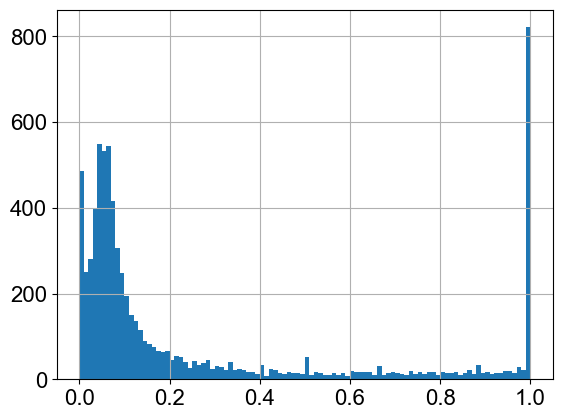

In [12]:
culvert['urbanized_pro']. hist(bins=100)

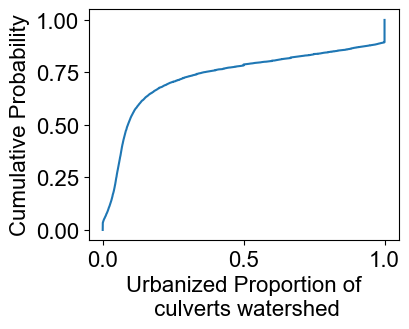

In [13]:
# ECDF plot
urbanization_data=np.sort(culvert['urbanized_pro'])
cdf = np.arange(1, len(urbanization_data) + 1) / len(urbanization_data)
plt.figure(figsize=(4, 3))
plt.plot(urbanization_data, cdf, marker=None, linestyle='-')
plt.xlabel('Urbanized Proportion of\n culverts watershed')
plt.ylabel('Cumulative Probability')
#plt.title('CDF of urbanized proportion of culverts watersheds')
plt.show()

In [14]:
# Display the first row of the culvert DataFrame
first_row = culvert.iloc[1]
print(first_row)

BIN                                                                                  C810540
Ini_lon                                                                           -73.413932
Ini_lat                                                                            42.345825
lonsnap_10                                                                        -73.413873
latsnap_10                                                                         42.345798
Area_10                                                                            70.297816
Peri_10                                                                            59.702565
LFP_len_10                                                                         22.615254
LFP_S_10                                                                               8.192
Bas_S_10                                                                           10.916072
cul_S10                                                               

In [15]:
# Date and time
now = datetime.datetime.now()
print(f"Date and time: {now}")


Date and time: 2025-04-30 21:02:50.258838


In [16]:
%load_ext watermark
# Print the Python version and some dependencies
%watermark -v -m -p numpy,pandas,matplotlib,rasterio,geopandas,os,glob,tqdm

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.20.0

numpy     : 2.0.2
pandas    : 2.2.2
matplotlib: 3.8.4
rasterio  : 1.4.3
geopandas : 1.0.1
os        : unknown
glob      : unknown
tqdm      : 4.66.5

Compiler    : MSC v.1940 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 24
Architecture: 64bit

